In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import seaborn as sns

# spider plot functions
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# clustering functions
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# set plotting functions
matplotlib.rcParams['savefig.dpi'] = 500
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')
# get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
# define functions
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, fontsize=8):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=fontsize)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/A00b_Strains_Control_HepaticCells_Spider_Plot/'
# dataDirectory = '/home/h1bennet/strains/data/RNA/control_lsec/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [4]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

Set terms to iterate through for making spider plots

In [5]:
cell_type_list = ['/home/h1bennet/strains_rna/results/H00_Strains_Control_Hepatocyte_RNA/',
                     '/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/',
                     '/home/h1bennet/strains_rna/results/L00_Strains_Control_LSEC_RNA/',
                     '/home/h1bennet/strains_rna/results/S00_Strains_Control_Stellate_RNA/']
cell_type = ['hepatocyte', 'kupffer', 'lsec', 'stellate']
strain = ['aj', 'balb', 'c57']

# Union Set

/home/h1bennet/strains_rna/results/H00_Strains_Control_Hepatocyte_RNA/
hepatocyte


/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:56: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/
kupffer
/home/h1bennet/strains_rna/results/L00_Strains_Control_LSEC_RNA/
lsec
/home/h1bennet/strains_rna/results/S00_Strains_Control_Stellate_RNA/
stellate


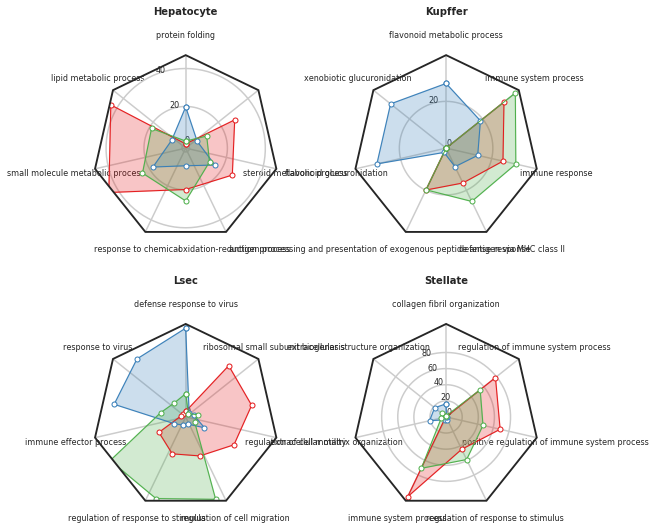

In [6]:
# select whether to use union or intersection gene set
comparison = 'union'
strain_comp = [i+'_'+comparison for i in strain]
theta = radar_factory(7, frame='polygon')

fig, axs = plt.subplots(2, 2,
                        figsize=(8,8),
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.85, bottom=0.05)

for path, cell, ax in zip(cell_type_list, cell_type, axs.flat):    
    print(path)
    print(cell)
    df_dict = {}
    # extract terms
    for i in np.sort(glob.glob(path+'/gene_lists/*go/biological_process.txt')):
        df = pd.read_csv(i, sep='\t', index_col=0)
        df_dict[i.split('/')[8].split('_'+cell)[0]] = df
    
    # grab top terms
    n=3
    top_terms = []
    for i in strain_comp:
        top_terms.extend(df_dict[i].sort_values('logP', ascending=True).index.tolist()[:n])

    top_terms_set = set(top_terms)
    
    # save full df for ty...
    df_full = df_dict[strain_comp[0]].loc[top_terms_set, :]
    df_full = df_full.merge(df_dict[strain_comp[1]].loc[top_terms_set, :],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df_full = df_full.merge(df_dict[strain_comp[2]].loc[top_terms_set, :],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    df_full.to_csv('./GO_results_top_'+str(n)+'terms.txt',
                   sep='\t')
    
    # extract dataframe
    df = df_dict[strain_comp[0]].loc[top_terms_set, ['Term', 'logP']]
    df = df.merge(df_dict[strain_comp[1]].loc[top_terms_set, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df = df.merge(df_dict[strain_comp[2]].loc[top_terms_set, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    # cluster terms
    d2 = dist.pdist(df.iloc[:, 1:])
    D2 = dist.squareform(d2)
    Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z2 = sch.dendrogram(Y2, no_plot=True)
    
    # make plot
    theta = radar_factory(df.shape[0], frame='polygon')

    # set axis lines
    ax.set_rgrids(np.arange(0,100,20),
                  fontsize=8)

    ax.set_title(cell.capitalize(), weight='bold', size='medium', position=(0.5, 1.2),
                 horizontalalignment='center', verticalalignment='center')
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    lists = ['logP_aj', 'logP_balb', 'logP']

    for color, logp_lists in zip(colors, lists):
        ax.plot(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                linewidth=1,
                marker='o',
                markersize=5,
                markerfacecolor='white')
        ax.fill(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                alpha=0.25)
    ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                     fontsize=8)
    
plt.savefig('./figures/spider_plot_union_top_'+str(n)+'_terms.pdf',
            bbox_inches='tight')

# Union set - selected terms

In [7]:
terms = [['GO:0044281', 'GO:0006629', 'GO:0010941',
           'GO:0006457', 'GO:0055114', 'GO:0031330',
           'GO:0006629', 'GO:0008202', 'GO:0044255'],
         ['GO:0002376', 'GO:0002504', 'GO:0006952',
           'GO:0009812', 'GO:0009605', 'GO:0043410',
           'GO:0006950', 'GO:0034341', 'GO:0051707'],
         ['GO:2000145', 'GO:0048583', 'GO:0030155',
           'GO:0051607', 'GO:0002252', 'GO:0010565',
           'GO:1903670', 'GO:1901342', 'GO:0015711'],
         ['GO:0006954', 'GO:0009611', 'GO:0007166',
           'GO:0030198', 'GO:0030199', 'GO:0051607',
           'GO:0032964', 'GO:0022610', 'GO:0006952']]
         

/home/h1bennet/strains_rna/results/H00_Strains_Control_Hepatocyte_RNA/
hepatocyte


/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:50: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


/home/h1bennet/strains_rna/results/K00_Strains_Control_Kupffer_RNA/
kupffer
/home/h1bennet/strains_rna/results/L00_Strains_Control_LSEC_RNA/
lsec
/home/h1bennet/strains_rna/results/S00_Strains_Control_Stellate_RNA/
stellate


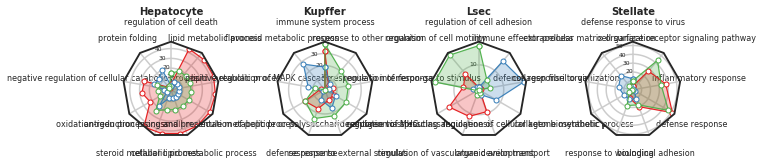

In [8]:
# select whether to use union or intersection gene set
comparison = 'union'
strain_comp = [i+'_'+comparison for i in strain]
theta = radar_factory(9, frame='polygon')


fig, axs = plt.subplots(1, 4,
                        figsize=(10,2),
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.6)

for path, cell, go, ax in zip(cell_type_list, cell_type, terms, axs.flat):    
    print(path)
    print(cell)
    
    df_dict = {}
    # extract terms
    for i in np.sort(glob.glob(path+'/gene_lists/*go/biological_process.txt')):
        df = pd.read_csv(i, sep='\t', index_col=0)
        df_dict[i.split('/')[8].split('_'+cell)[0]] = df
    
    # extract dataframe
    df = df_dict[strain_comp[0]].loc[go, ['Term', 'logP']]
    df = df.merge(df_dict[strain_comp[1]].loc[go, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df = df.merge(df_dict[strain_comp[2]].loc[go, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    # save full df for ty...
    df_full = df_dict[strain_comp[0]].loc[go, :]
    df_full = df_full.merge(df_dict[strain_comp[1]].loc[go, :],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df_full = df_full.merge(df_dict[strain_comp[2]].loc[go, :],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    df_full.to_csv('./GO_results_curated_terms_'+cell+'.txt',
                   sep='\t')
    
    # cluster terms
    d2 = dist.pdist(df.iloc[:, 1:])
    D2 = dist.squareform(d2)
    Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z2 = sch.dendrogram(Y2, no_plot=True)
    
    # make plot
    theta = radar_factory(df.shape[0], frame='polygon')

    # set axis lines
    ax.set_rgrids(np.arange(0,100,10),
                  fontsize=6)

    ax.set_title(cell.capitalize(), weight='bold', size=10, position=(0.5, 1.0),
                 horizontalalignment='center', verticalalignment='center')
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    lists = ['logP_aj', 'logP_balb', 'logP']

    for color, logp_lists in zip(colors, lists):
        ax.plot(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                linewidth=1,
                marker='o',
                markersize=5,
                markerfacecolor='white')
        ax.fill(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                alpha=0.25)
    ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                     fontsize=8)
    
plt.savefig('./figures/spider_plot_union_curated_terms.pdf',
            bbox_inches='tight')

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


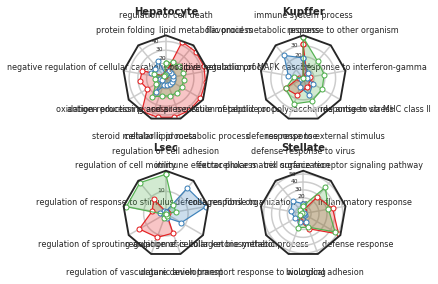

In [40]:
# select whether to use union or intersection gene set
comparison = 'union'
strain_comp = [i+'_'+comparison for i in strain]
theta = radar_factory(9, frame='polygon')


fig, axs = plt.subplots(2, 2,
                        figsize=(4, 2/3*6.85),
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.6)

for path, cell, go, ax in zip(cell_type_list, cell_type, terms, axs.flat):    
    df_dict = {}
    # extract terms
    for i in np.sort(glob.glob(path+'/gene_lists/*go/biological_process.txt')):
        df = pd.read_csv(i, sep='\t', index_col=0)
        df_dict[i.split('/')[8].split('_'+cell)[0]] = df
    
    # extract dataframe
    df = df_dict[strain_comp[0]].loc[go, ['Term', 'logP']]
    df = df.merge(df_dict[strain_comp[1]].loc[go, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df = df.merge(df_dict[strain_comp[2]].loc[go, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    # cluster terms
    d2 = dist.pdist(df.iloc[:, 1:])
    D2 = dist.squareform(d2)
    Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z2 = sch.dendrogram(Y2, no_plot=True)
    
    # make plot
    theta = radar_factory(df.shape[0], frame='polygon')

    # set axis lines
    ax.set_rgrids(np.arange(0,100,10),
                  fontsize=6)

    ax.set_title(cell.capitalize(), weight='bold', size=10, position=(0.5, 1.2),
                 horizontalalignment='center', verticalalignment='center')
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    lists = ['logP_aj', 'logP_balb', 'logP']

    for color, logp_lists in zip(colors, lists):
        ax.plot(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                linewidth=1,
                marker='o',
                markersize=5,
                markerfacecolor='white')
        ax.fill(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                alpha=0.25)
    ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                     fontsize=8)
    
plt.savefig('./figures/spider_plot_union_curated_terms_2by2.pdf',
            bbox_inches='tight')

# Intersection set

In [ ]:
# select whether to use union or intersection gene set
comparison = 'intersection'
strain_comp = [i+'_'+comparison for i in strains]

fig, axs = plt.subplots(2, 2,
                        figsize=(8,8),
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.4, hspace=0.4, top=0.85, bottom=0.05)

for path, cell, ax in zip(cell_type_list, cell_type, axs.flat):    
    df_dict = {}
    # extract terms
    for i in np.sort(glob.glob(path+'/gene_lists/*go/biological_process.txt')):
        df = pd.read_csv(i, sep='\t', index_col=0)
        df_dict[i.split('/')[8].split('_'+cell)[0]] = df
    
    # grab top terms
    n=3
    top_terms = []
    for i in strain_comp:
        top_terms.extend(df_dict[i].sort_values('logP', ascending=True).index.tolist()[:n])

    top_terms_set = set(top_terms)
    
    # extract dataframe
    df = df_dict[strain_comp[0]].loc[top_terms_set, ['Term', 'logP']]
    df = df.merge(df_dict[strain_comp[1]].loc[top_terms_set, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('_'+strain[0], '_'+strain[1]))
    df = df.merge(df_dict[strain_comp[2]].loc[top_terms_set, ['logP']],
                  left_index=True,
                  right_index=True,
                  suffixes=('', '_'+strain[2]))
    
    # cluster terms
    d2 = dist.pdist(df.iloc[:, 1:])
    D2 = dist.squareform(d2)
    Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z2 = sch.dendrogram(Y2, no_plot=True)
    
    # make plot
    theta = radar_factory(df.shape[0], frame='polygon')

    # set axis lines
    ax.set_rgrids(np.arange(0,100,5),
                  fontsize=8)

    ax.set_title(cell.capitalize(), weight='bold', size='medium', position=(0.5, 1.2),
                 horizontalalignment='center', verticalalignment='center')
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    lists = ['logP_aj', 'logP_balb', 'logP']

    for color, logp_lists in zip(colors, lists):
        ax.plot(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                linewidth=1,
                marker='o',
                markersize=5,
                markerfacecolor='white')
        ax.fill(theta,
                -df[logp_lists].iloc[Z2['leaves']],
                color=color,
                alpha=0.25)
    ax.set_varlabels(df['Term'].iloc[Z2['leaves']],
                     fontsize=8)
    
plt.savefig('./figures/spider_plot_intersection_top_'+str(n)+'_terms.pdf',
            bbox_inches='tight')